# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [ ]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features) if self.w0 is None else self.w0

        for iteration in range(self.max_iter):
            if self.gd_type == 'stochastic':
                idx = np.random.randint(n_samples)
                X_batch = X[idx:idx + 1]
                y_batch = y[idx:idx + 1]
            else:
                X_batch = X
                y_batch = y

            grad = self.calc_gradient(X_batch, y_batch)
            self.w -= self.eta * grad

            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            if np.linalg.norm(grad) < self.tolerance:
                break
        return self


    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        else:
          return 1 / (1 + np.exp(-X.dot(self.w)))
        pass


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        else:
          return (self.predict_proba(X) >= 0.5).astype(int)
        pass

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        linear_preds = X.dot(self.w)
        probs = 1 / (1 + np.exp(-linear_preds))
        return X.T.dot(probs - y) / X.shape[0]
        pass

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        linear_preds = X.dot(self.w)
        probs = 1 / (1 + np.exp(-linear_preds))
        return -np.mean(y * np.log(probs+1e-15) + (1-y) * np.log(1-probs+1e-15))
        pass

Теперь проверим работу вашего класса на синтетических данных.

In [ ]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [ ]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss

model = LogReg(gd_type='full', tolerance=1e-4, max_iter=1000, eta=0.1)
model.fit(X_train, y_train)

sel_model = LogisticRegression(solver='saga', max_iter=1000)
sel_model.fit(X_train, y_train)

y_pred_model = model.predict(X_test)
y_pred_sel_model = sel_model.predict(X_test)

print("Accuracy model:", accuracy_score(y_test, y_pred_model))
print('-' * 40)
print("Accuracy sel_model:", accuracy_score(y_test, y_pred_sel_model))
print('-' * 40)
print("Log Loss model:", log_loss(y_test, model.predict_proba(X_test)))
print('-' * 40)
print("Log Loss sel_model:", log_loss(y_test, sel_model.predict_proba(X_test)[:, 1]))

Accuracy model: 0.8488666666666667
----------------------------------------
Accuracy sel_model: 0.8486666666666667
----------------------------------------
Log Loss model: 0.3481963902665826
----------------------------------------
Log Loss sel_model: 0.3479281906740369


In [ ]:
sel_model.predict_proba(X_test)[:, 1]

array([0.56220534, 0.87008027, 0.97389372, ..., 0.52361858, 0.65347649,
       0.76199754])

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings("ignore")

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test))

print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)))
print('-' * 40)
print("PR-AUC:", auc(recall, precision))

ROC-AUC: 0.9258430929663389
----------------------------------------
PR-AUC: 0.9245921740897283


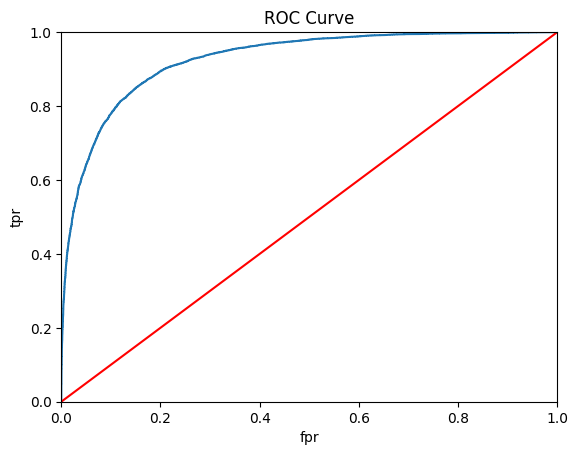

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test))
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r-')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.show()

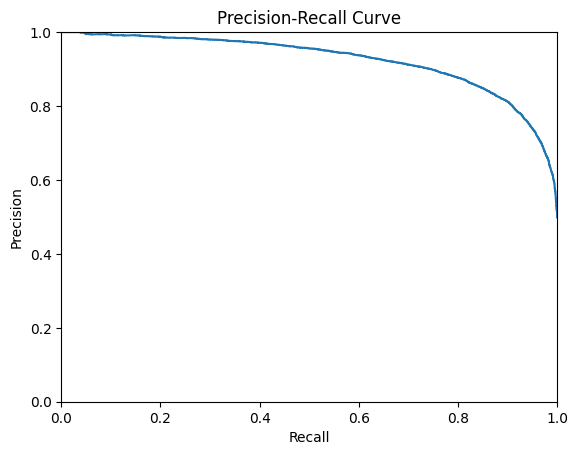

In [ ]:
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [ ]:
PATH_TO_DATASET = 'train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [ ]:
from sklearn.preprocessing import OneHotEncoder


X_train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
381341,1,1,8,0,0,0,0,1,0,0,...,2,1,5,8,0,1,1,0,0,0
1327969,2,2,2,1,0,0,0,0,1,0,...,6,0,2,5,0,1,1,0,1,0
601794,0,1,2,0,0,1,0,0,0,0,...,9,1,5,3,0,0,0,0,1,1
632925,6,1,11,1,0,0,1,0,0,0,...,8,1,2,4,0,1,0,0,1,1
74864,3,1,5,1,0,0,0,1,0,0,...,9,2,3,8,0,1,1,1,0,0


In [ ]:
c_columns = [col for col in X_train.columns if col.endswith('cat')]

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
train_encoded = ohe.fit_transform(X_train[c_columns])

X_train_enсore = pd.concat([pd.DataFrame(train_encoded,
                                    columns=ohe.get_feature_names_out(c_columns),
                                    index=X_train.index),
                                    X_train.drop(columns=c_columns)], axis=1)

In [ ]:
test_encoded = ohe.transform(X_test[c_columns])

X_test_encore = pd.concat([pd.DataFrame(test_encoded,
                                    columns=ohe.get_feature_names_out(c_columns),
                                    index=X_test.index),
                                    X_test.drop(columns=c_columns)], axis=1)

In [ ]:
X_test_encore.shape, X_test_encore.shape

((119043, 213), (119043, 213))

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [ ]:
# Логрег
%%time

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_enсore, y_train)

CPU times: user 1min 56s, sys: 10.8 s, total: 2min 7s
Wall time: 1min 19s


LogisticRegression(max_iter=1000)

In [ ]:
# SVM (проговорили про обучние на 20к) (обучается уже час пока что остановил иду дальше)

#%%time
#from sklearn.svm import SVC

#s = SVC(kernel='linear', probability=True)
#s.fit(X_train_enсore[:20000], y_train[:20000])

In [ ]:
# KNN
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_enсore, y_train)

CPU times: user 657 ms, sys: 301 ms, total: 957 ms
Wall time: 956 ms


KNeighborsClassifier()

In [ ]:
print("ROC-AUC LogReg:", roc_auc_score(y_test, lr.predict_proba(X_test_encore)[:, 1]))
print('-' * 40)
print("ROC-AUC KNN:", roc_auc_score(y_test, knn.predict_proba(X_test_encore)[:, 1]))
print('-' * 40)
#print("ROC-AUC SVM:", roc_auc_score(y_test, s.predict_proba(X_test_enc)[:, 1]))

ROC-AUC (LogReg): 0.6381060064255387
----------------------------------------


In [ ]:
# LR
from sklearn.model_selection import GridSearchCV

params = {'C': np.arange(1, 11),
          'class_weight': [
            None,
            'balanced']}

gs_lr = GridSearchCV(LogisticRegression(max_iter=1000), params, cv=3, scoring='roc_auc')

gs_lr.fit(X_train_enсore[:20000], y_train[:20000])


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'class_weight': [None, 'balanced']},
             scoring='roc_auc')

In [ ]:
from sklearn.svm import SVC

In [ ]:
# SVC  (KeyboardInterrupt выкатило ошибку, изменю кол-во фолдов)

%%time

params = {'kernel' : ['rbf','poly','sigmoid','linear']}

gs_svc = GridSearchCV(SVC(), params, cv=2, scoring='roc_auc')

gs_svc.fit(X_train_enсore[:20000], y_train[:20000])

print(gs_svc.best_score_)
print(gs_svc.best_params_)

0.5298347024597925
{'kernel': 'linear'}
CPU times: user 1h 3min 13s, sys: 4 s, total: 1h 3min 17s
Wall time: 1h 3min 35s


In [ ]:
# KNN

%%time
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance']
}

gs_knn = GridSearchCV(KNeighborsClassifier(), params, cv=3, scoring='roc_auc')

gs_knn.fit(X_train_enсore[:20000], y_train[:20000])

print(gs_knn.best_score_)
print(gs_knn.best_params_)

0.5176331195164586
{'n_neighbors': 24, 'weights': 'uniform'}
CPU times: user 6min, sys: 410 ms, total: 6min
Wall time: 6min 2s


### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [ ]:
from sklearn.preprocessing import StandardScaler

num_feat = [col for col in X_train_enсore.columns
                            if 'cat' not in col and not col.endswith('bin')]

scaler = StandardScaler()
X_train_scaled = X_train_enсore.copy()
X_test_scaled = X_test_encore.copy()

X_train_scaled[num_feat] = scaler.fit_transform(X_train_enсore[num_feat])
X_test_scaled[num_feat] = scaler.transform(X_test_encore[num_feat])

len(num_feat)

26

In [ ]:
%%time

from sklearn.feature_selection import SelectFromModel

estimator = LogisticRegression()
selector = SelectFromModel(estimator)
selector = selector.fit(X_train_scaled, y_train)

coef = np.abs(selector.estimator_.coef_).flatten()
top_150_feat = [X_train_scaled.columns[i] for i in np.argsort(coef)[-150:]]

CPU times: user 9.01 s, sys: 456 ms, total: 9.47 s
Wall time: 9.69 s


ROC-AUC: 0.6386263934306508


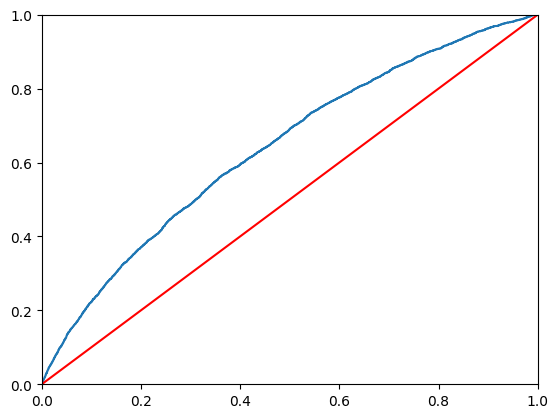

CPU times: user 7.5 s, sys: 931 ms, total: 8.43 s
Wall time: 8.51 s


In [ ]:
%%time
from sklearn.metrics import roc_curve

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled[top_150_feat], y_train)
lr_pred = lr.predict_proba(X_test_scaled[top_150_feat])[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, lr_pred))

fpr, tpr, threshold = roc_curve(y_test, lr_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r-')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [ ]:
top_200_feat = [X_train_scaled.columns[i] for i in np.argsort(coef)[-200:]]

selector = selector.fit(X_train_scaled[top_200_feat], y_train)
coef = np.abs(selector.estimator_.coef_).flatten()
top_150_feat = [X_train_scaled.columns[i] for i in np.argsort(coef)[-150:]]

lr_2 = LogisticRegression(max_iter=1000)
lr_2.fit(X_train_scaled[top_150_feat], y_train)
lr_pred_2 = lr_2.predict_proba(X_test_scaled[top_150_feat])[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, lr_pred_2))

ROC-AUC: 0.6198189833591911


### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'C': np.arange(1, 25)}

gs_lr = GridSearchCV(LogisticRegression(max_iter=10000), params, cv=3, scoring='roc_auc')

gs_lr.fit(X_train_scaled[:20000], y_train[:20000])

print(f"Лучший C: {gs_lr.best_params_['C']}")
print(f"Кол-во ненулевых весов: {np.sum(gs_lr.best_estimator_.coef_ != 0)}")
print(f"Кол-во ненулевых весов с округлением: "
      f"{np.sum(np.round(gs_lr.best_estimator_.coef_, 2) != 0)}")

Лучший C: 1
Кол-во ненулевых весов: 213
Кол-во ненулевых весов с округлением: 207


### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [ ]:
%%time

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=X_train_scaled[num_feat].shape[1] // 2 )
X_train_selected = selector.fit_transform(X_train_scaled[num_feat],
                                          y_train)
# их всего 26, вряд ли будет большой эффект

f_features = [X_train_scaled.columns[i] for i in selector.get_support(indices=True)]

CPU times: user 500 ms, sys: 266 ms, total: 765 ms
Wall time: 1.74 s


In [ ]:
lr_K = LogisticRegression(max_iter=1000)
lr_K.fit(pd.concat([X_train_scaled.drop(columns=num_feat),
                    X_train_scaled[f_features]], axis=1), y_train)
lr_pred_K = lr_K.predict_proba(pd.concat([X_test_scaled.drop(columns=num_feat),
                    X_test_scaled[f_features]], axis=1))[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, lr_pred_K).round(2))

ROC-AUC: 0.63


### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
%%time

X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_scaled,
                                                  y_train, test_size=0.3, random_state=42)

rfe = RFE(LogisticRegression(max_iter=1000),
          n_features_to_select=150, step=1)
rfe.fit_transform(X_train_part[:10000], y_train_part[:10000])

CPU times: user 10.3 s, sys: 258 ms, total: 10.6 s
Wall time: 10.8 s


array([[ 0.        ,  1.        ,  0.        , ...,  0.23346357,
         0.53015762,  0.        ],
       [ 1.        ,  0.        ,  0.        , ..., -1.26508216,
        -0.15538797,  0.        ],
       [ 1.        ,  0.        ,  0.        , ..., -2.01435503,
         0.53015762,  0.        ],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.51580929,
         1.90124882,  0.        ],
       [ 1.        ,  0.        ,  0.        , ..., -0.51580929,
        -0.15538797,  0.        ],
       [ 1.        ,  0.        ,  0.        , ...,  0.98273644,
        -1.52647917,  0.        ]])

In [ ]:
lr_R = LogisticRegression(max_iter=1000)
lr_R.fit(X_train_scaled[X_train_scaled.columns[rfe.support_]], y_train)
lr_pred_R = lr_R.predict_proba(X_test_scaled[X_test_scaled.
                                             columns[rfe.support_]])[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, lr_pred_R).round(2))

ROC-AUC: 0.63


In [ ]:
%%time

def greedy_selection(X, y, n_features=150):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    remaining_ft = list(X.columns)

    while len(remaining_ft) > n_features:
        scores = {}

        for feature in remaining_ft:
            temp_features = [f for f in remaining_ft if f != feature]

            model = LogisticRegression(max_iter=1000)
            model.fit(X_train[temp_features], y_train)

            preds = model.predict_proba(X_val[temp_features])[:, 1]
            scores[feature] = roc_auc_score(y_val, preds)

        del_feature = max(scores, key=scores.get)
        remaining_ft.remove(del_feature)

    return remaining_ft

selected_ft = greedy_selection(X_train_scaled[:10000], y_train[:10000],
                                       n_features=X_train_scaled.shape[1] - 1)

CPU times: user 24.8 s, sys: 79.6 ms, total: 24.8 s
Wall time: 25 s


In [ ]:
%%time

selected_ft = greedy_selection(X_train_scaled[:10000], y_train[:10000],
                                       n_features=150)

CPU times: user 19min 24s, sys: 4.61 s, total: 19min 29s
Wall time: 19min 40s


In [ ]:
lr_R = LogisticRegression(max_iter=1000)
lr_R.fit(X_train_scaled[selected_ft], y_train)

lr_pred_R = lr_R.predict_proba(X_test_scaled[selected_ft])[:, 1]
roc_auc_score(y_test, lr_pred_R)

0.6222203328702421

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

Если не скоращать нашу выборку в некоторых местах будет очень долгое обучение, а местами крашится процесс вцелом. Втроенный метод куда практиченее и быстрее с ним открывается огромный спектр вариативности, что играет немалую роль. Все таки для разных методов надо правильно подбирвать параметры иначе сячастья не видать :(

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [ ]:
from sklearn.model_selection import train_test_split

PATH = 'trainhw.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
pd.isna(data).sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [ ]:
data.fillna('', inplace=True)

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [ ]:
pd.concat([data.select_dtypes(include='number').nunique(),
           pd.notna(data.select_dtypes(include='number')).sum()], axis=1)

,0,1
id,7613,7613
target,2,7613


- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [ ]:
data.target.value_counts()

,count
target,
0,4342
1,3271


- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [ ]:
data['rework_text'] = data['keyword'] + " " + data['location'] + " " + data['text']
data.drop(['keyword', 'location', 'text'], axis=1, inplace=True)

In [ ]:
data.head()

,id,target,rework_text
0,1,1,Our Deeds are the Reason of this #earthquake...
1,4,1,Forest fire near La Ronge Sask. Canada
2,5,1,All residents asked to 'shelter in place' ar...
3,6,1,"13,000 people receive #wildfires evacuation ..."
4,7,1,Just got sent this photo from Ruby #Alaska a...


- Наконец, поделите данные на тренировочную и тестовую выборки.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1),
                                                    data.target,
                                                    test_size=0.25,
                                                    random_state=42)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
nltk.download('punkt_tab')

X_train['text_token'] = X_train['rework_text'].apply(
    lambda x: ' '.join([w for w in word_tokenize(x) if w.isalpha()]))

cnt_vector = CountVectorizer()
X_cnt = cnt_vector.fit_transform(X_train['text_token'])
X_cnt.shape

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


(5709, 13935)

In [ ]:
pd.DataFrame(X_cnt.toarray(), columns=cnt_vector.get_feature_names_out()).head()

,aa,aaaa,aaaaaaallll,aaarrrgghhh,aan,aannnnd,aar,aarhus,aaronthefm,ab,...,zzzz,åá,åç,åè,åê,åêfedex,åêi,ìït,ìñ,ìü
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test['text_token'] = X_test['rework_text'].apply(
    lambda x: ' '.join([w for w in word_tokenize(x) if w.isalpha()]))

X_test_cnt = cnt_vector.transform(X_test['text_token'])

- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [ ]:
%%time

lr = LogisticRegression(max_iter=1000)
lr.fit(X_cnt, y_train)
prediction = lr.predict(X_test_cnt)

CPU times: user 139 ms, sys: 11 µs, total: 139 ms
Wall time: 138 ms


In [ ]:
print("f1-score:", f1_score(y_test, prediction, average='weighted'))

f1-score: 0.7998183277825253


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [ ]:
from sklearn.svm import SVC

In [ ]:
%%time

svm = SVC()
svm.fit(X_cnt, y_train)
prediction_svm = svm.predict(X_test_cnt)

CPU times: user 7.31 s, sys: 11.5 ms, total: 7.32 s
Wall time: 10.4 s


In [ ]:
print("f1-score:", f1_score(y_test, prediction_svm, average='weighted'))

f1-score: 0.8061285848813435


In [ ]:
print("result", (f1_score(y_test, prediction_svm, average='weighted')-f1_score(y_test, prediction, average='weighted')))

result 0.006310257098818273


SVM показал себя лучше, но не на много, относительно недольше обучался, разницу пожно посмотреть в result

### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Ваши выводы здесь.

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

## Чей кот?

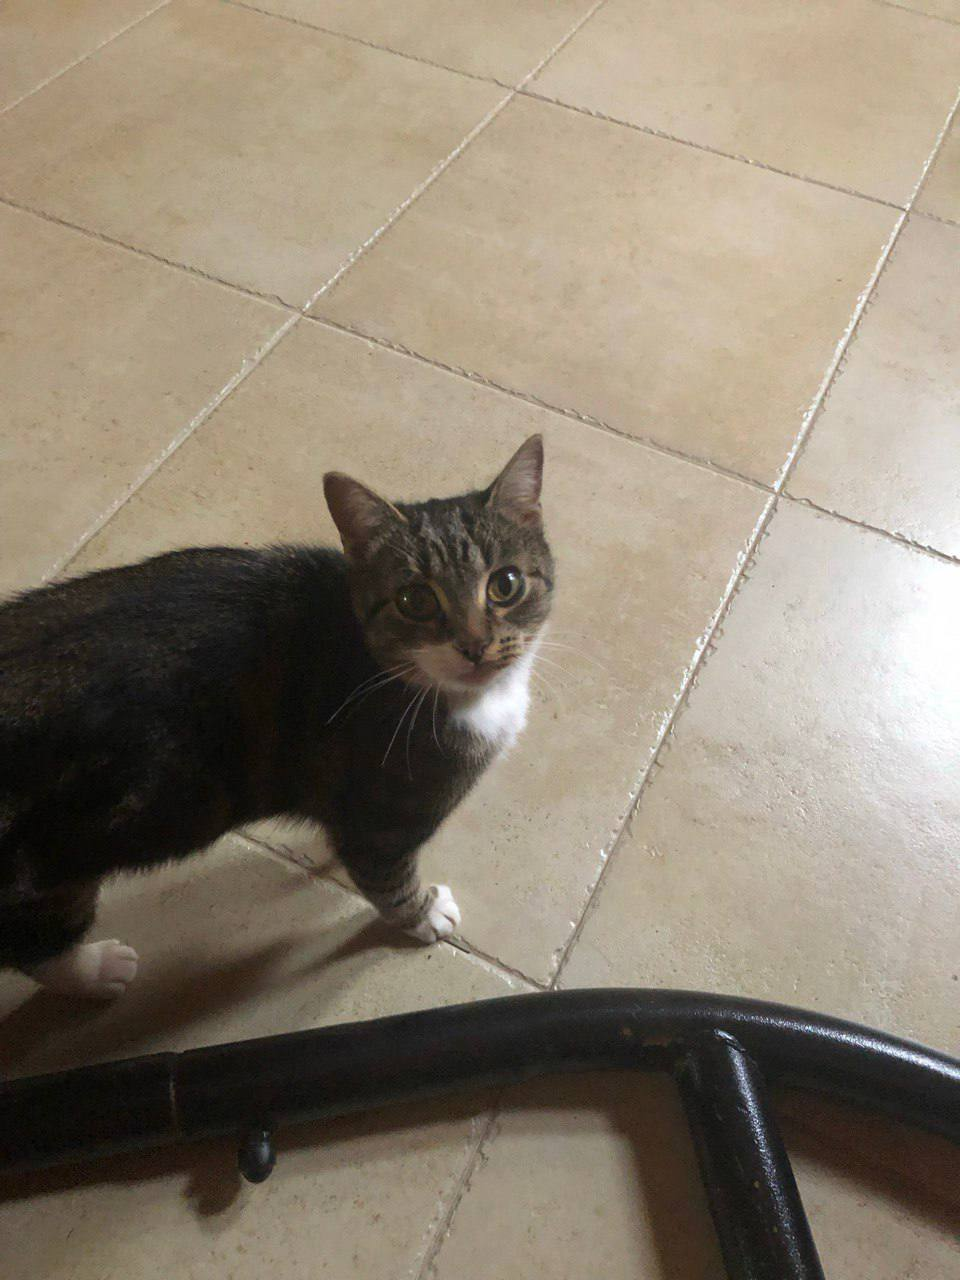

Сабрины